In [1]:
import numpy as np
class Perceptron(object):
    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X,y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            
            self.errors_.append(errors)
        return self
    
    def net_input(self,X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [2]:
import pandas as pd
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header=None)
df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


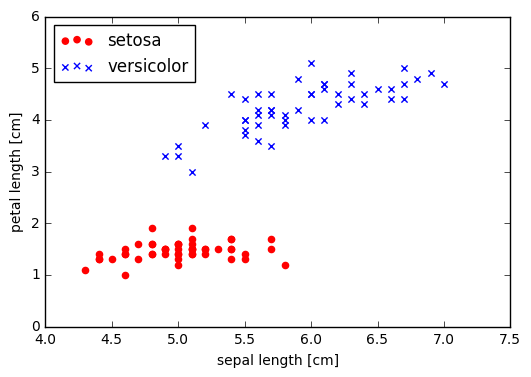

In [3]:
import matplotlib.pyplot as plt
import numpy as np
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)
X = df.iloc[0:100, [0,2]].values
plt.scatter(X[:50,0], X[:50,1],color='red', marker='o', label='setosa')
plt.scatter(X[50:100,0], X[50:100,1],color='blue', marker='x', label='versicolor')
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

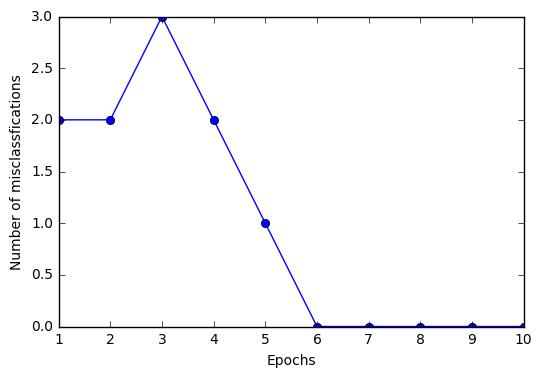

In [4]:
ppn = Perceptron(eta=0.1,n_iter=10)
ppn.fit(X,y)
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassfications')
plt.show()

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolutions=0.02):
    markers = ('s', 'x', '^', 'v')
    colors  = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() -1, X[:, 0].max() +1
    x2_min, x2_max = X[:, 1].min() -1, X[:, 1].max() +1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolutions),
                           np.arange(x2_min, x2_max, resolutions))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

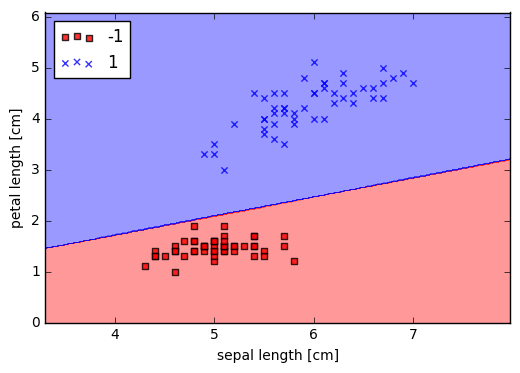

In [6]:
plot_decision_regions(X, y, classifier=ppn)

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()

In [7]:
class AdalineGD(object):
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum()  / 2
            self.cost_.append(cost)
            
        return self
    
    def net_input(self,X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return self.net_input(X)
    
    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)

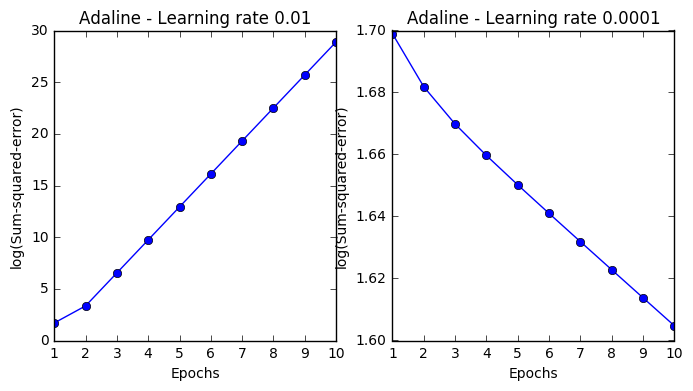

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ada1 = AdalineGD(n_iter=10,eta=0.01).fit(X, y)
ax[0].plot(range(1, len(ada1.cost_) + 1), np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

ada2 = AdalineGD(n_iter=10,eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.cost_) + 1), np.log10(ada2.cost_), marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.0001')

plt.show()

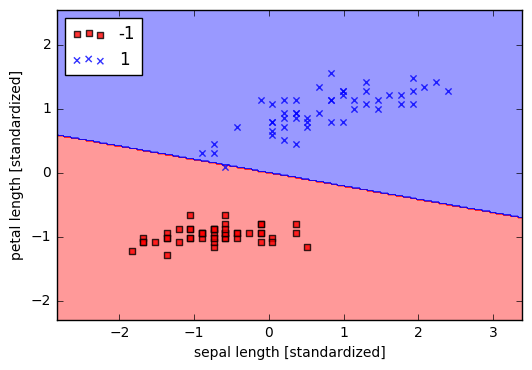

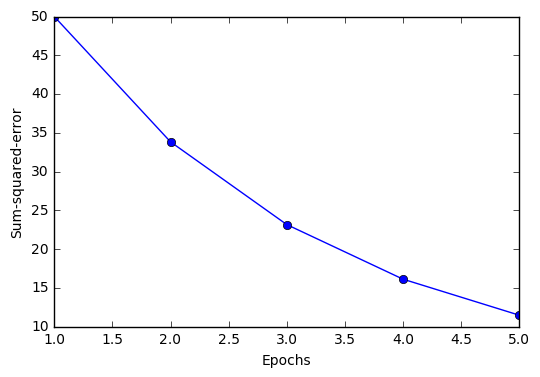

In [9]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

ada = AdalineGD(n_iter=5, eta=0.01)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)

plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.show()

In [10]:
from numpy.random import seed

class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        
    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X,y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
            
        return self
    
    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        
        return self
    
    def _shuffle(self, X, y):
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error **2
        
        return cost
    
    def net_input(self,X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        return self.net_input(X)
    
    def predict(self, X):
        return np.where(self.activation(X) >= 0.0, 1, -1)

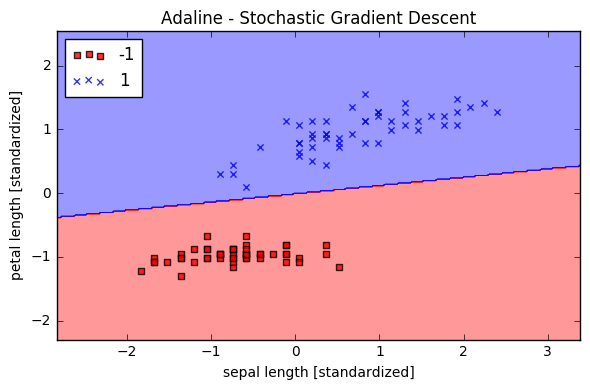

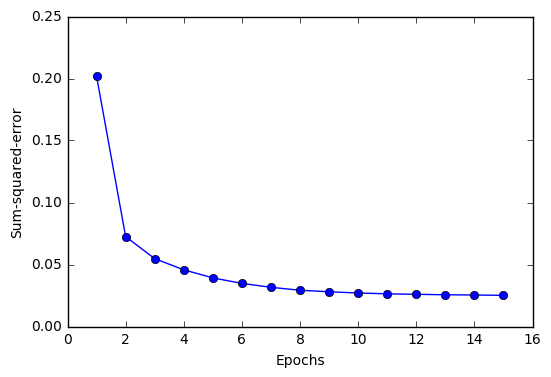

In [11]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)

plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.show()